<a href="https://colab.research.google.com/github/BrainConnection/Quantum_Algorithm/blob/main/2.%20TFIM%20VQNHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [1]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install qiskit[visualization]
!pip install qiskit-algorithms
!pip install qiskit-aer

!pip install scipy
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 31.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 7.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Options

# Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(channel="ibm_quantum",
                                  token="067e5c82606f0a1157dd554e2087d6b7a9b823dbaa4ad47b95c3337eab2e6cd9361719cc0470f4a98d1631b73b264a82577012a0b8ff32963d5964e6cc12c525",
                                  set_as_default=True,
                                  overwrite=True)

service = QiskitRuntimeService()
backend = service.backend("ibmq_qasm_simulator")

# Hamiltonian Diagonalization

$$ H = Σ Z_j Z_{j+1} - Σ X_j  $$

1D 5 Qubit System

In [3]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np
import matplotlib.pyplot as plt

In [4]:
interation = 1
bias = -1

coeff_list = [interation for _ in range(5)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "ZIIIZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(10):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)
hamiltonian_matrix = hamiltonian.to_matrix()

eigenvalue, eigenvector = np.linalg.eig(hamiltonian_matrix)

lowest_energy = np.min(eigenvalue)

np.real(lowest_energy)

-6.155367074350501

In [5]:
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)
hamiltonian_matrix = hamiltonian.to_matrix()

eigenvalue, eigenvector = np.linalg.eig(hamiltonian_matrix)

lowest_energy = np.min(eigenvalue)

np.real(lowest_energy)

-6.026674183332294

# VQE in Noiseless Simulator (Method 1)

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

## Ansatz, Hamiltonian, Sampler & Estimator Setting

In [6]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize

In [7]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

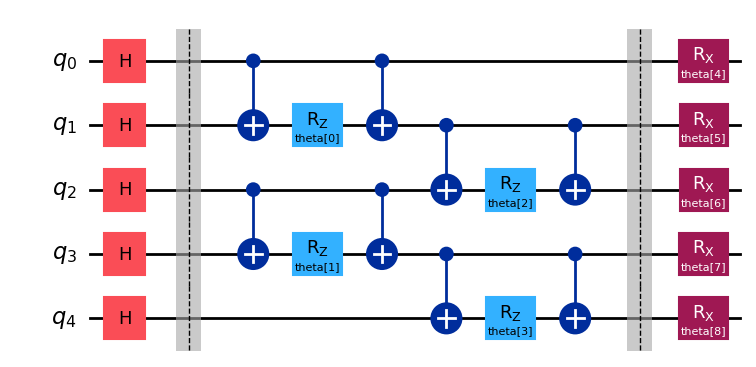

In [8]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

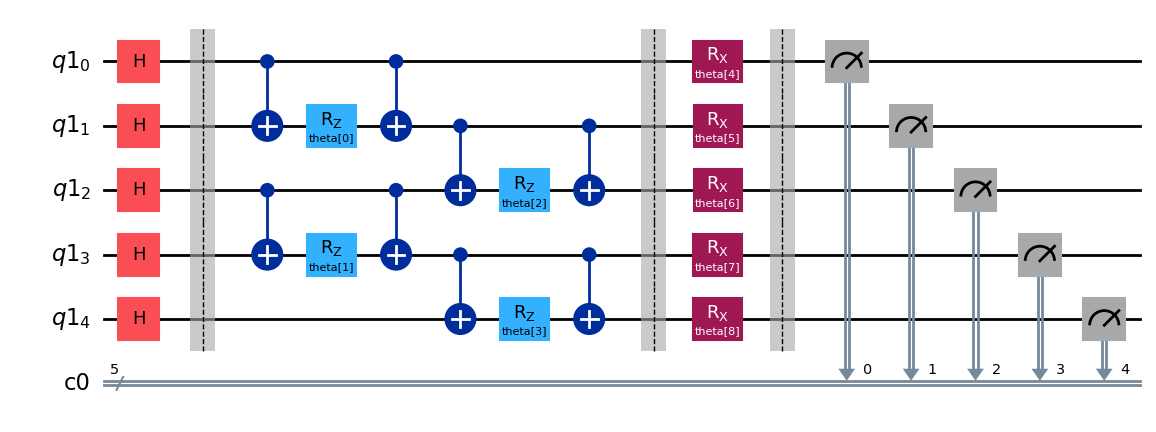

In [9]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

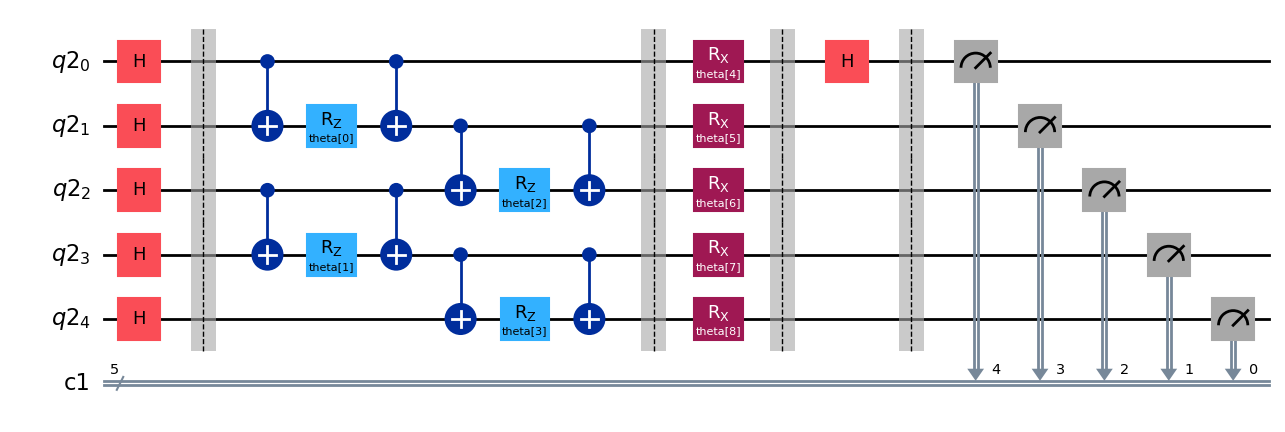

In [10]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

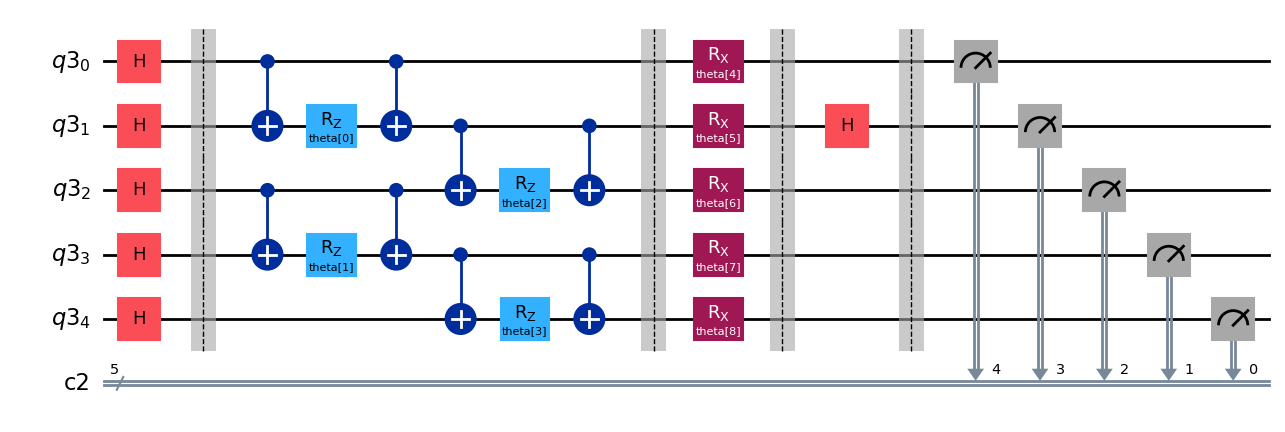

In [11]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

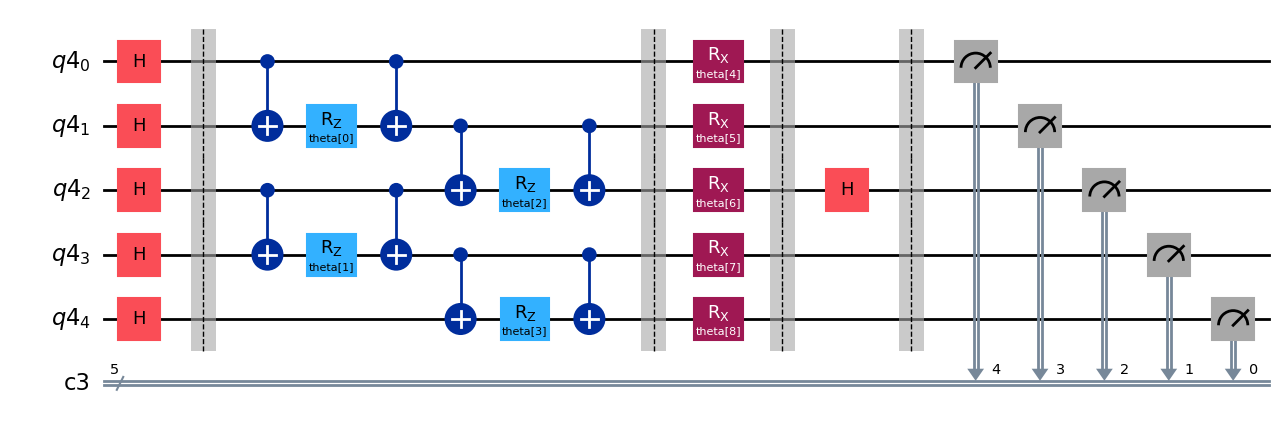

In [12]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

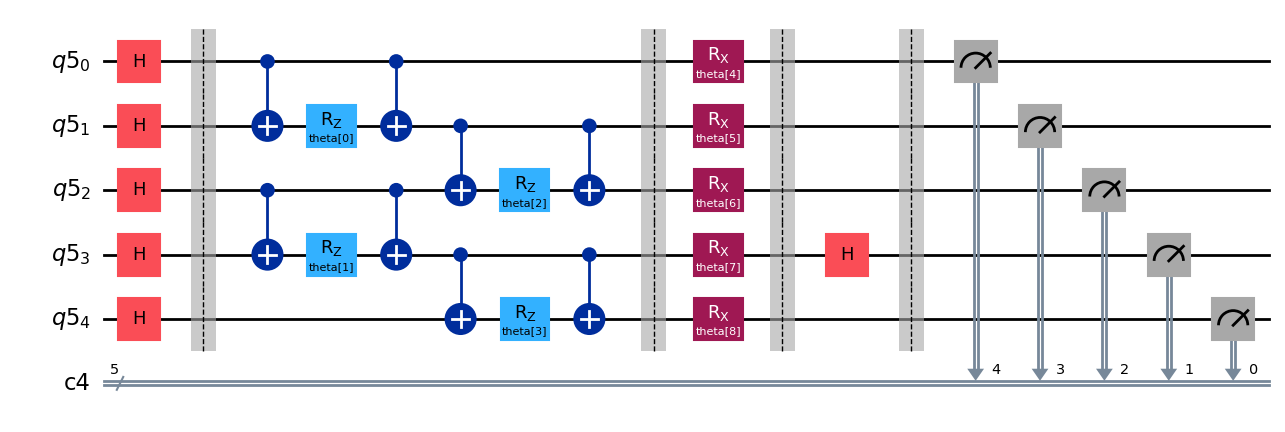

In [13]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

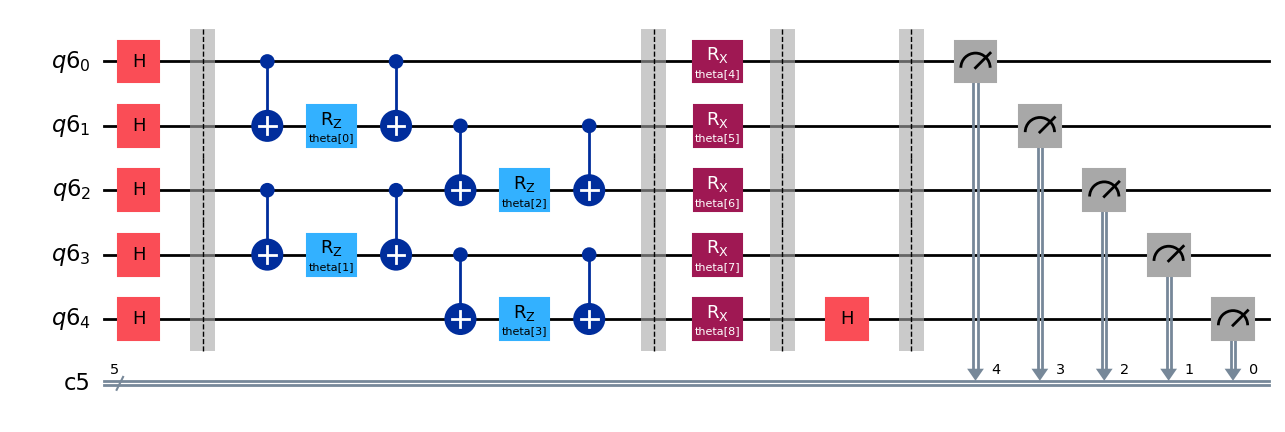

In [14]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

In [15]:
# Estimator & Sampler

estimator = Estimator()
sampler = Sampler()

## Cost Function for VQE

In [16]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result()
    return cost.values[0]

In [17]:
def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
  def callback(current_vector):
    callback_dict_vqe["iters"] += 1
    callback_dict_vqe["prev_vector"] = current_vector
    current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

    callback_dict_vqe["cost_history"].append(current_cost_vqe)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
      end="\r",
      flush=True,
    )

  return callback

## 1st Step : Optimizing Parameters in PQC

In [18]:
callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

options = dict()
options["maxiter"] = 50000
options["disp"] = True

np.random.seed(4)
x0 = 2 * np.pi * np.random.random(9)

x0

array([6.07602768, 3.43836163, 6.11155608, 4.49132135, 4.3839595 ,
       1.35773034, 6.13411331, 0.03914585, 1.58953506])

In [19]:
callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
res = minimize(
  cost_func_vqe,
  x0,
  args=(ansatz, hamiltonian, estimator),
  method="cobyla",
  callback=callback_vqe,
  options=options
)

In [20]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.897228656689823
       x: [ 5.803e+00  5.886e+00  6.681e+00  5.803e+00  4.715e+00
            3.139e+00  7.856e+00 -2.121e-03  1.573e+00]
    nfev: 1201
   maxcv: 0.0

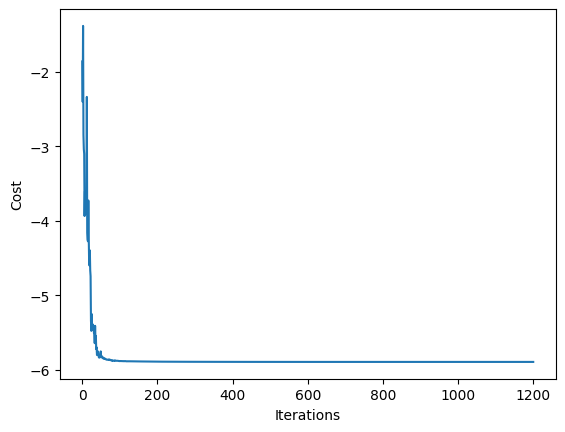

In [21]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict_vqe["iters"]), callback_dict_vqe["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [22]:
params_pqc = res.x
params_pqc

array([ 5.80341424e+00,  5.88567382e+00,  6.68073582e+00,  5.80344341e+00,
        4.71452869e+00,  3.13939431e+00,  7.85619779e+00, -2.12129562e-03,
        1.57296580e+00])

## Cost Function for VQNHE

In [23]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))

In [24]:
# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:50]
  W2 = parameter[50:250]
  W3 = parameter[250:270]
  c = parameter[270]

  W1 = W1.reshape(10,5)
  W2 = W2.reshape(20,10)
  W3 = W3.reshape(1,20)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  z2 = relu(a2)

  a3 = np.matmul(W3, z2)
  y = output_activate(c, a3)

  return y[0]

In [25]:
# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [26]:
def Z0Z1(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval

In [27]:
def X0(params_nn, ansatz_x0, params_pqc, sampler):
  job = sampler.run(ansatz_x0, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, ansatz_x1, params_pqc, sampler):
  job = sampler.run(ansatz_x1, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, ansatz_x2, params_pqc, sampler):
  job = sampler.run(ansatz_x2, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, ansatz_x3, params_pqc, sampler):
  job = sampler.run(ansatz_x3, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, ansatz_x4, params_pqc, sampler):
  job = sampler.run(ansatz_x4, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval

In [28]:
def norm(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [29]:
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]


hamiltonian_list = []
hamiltonian_list.append((operator_list[0], 1))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

cost = estimator.run(ansatz, hamiltonian, parameter_values=params_pqc).result()
print(cost.values[0])
print(Z0Z1(np.zeros(shape=271), ansatz_zz, params_pqc, sampler))
print()


hamiltonian_list = []
hamiltonian_list.append((operator_list[1], 1))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

cost = estimator.run(ansatz, hamiltonian, parameter_values=params_pqc).result()
print(cost.values[0])
print(Z1Z2(np.zeros(shape=271), ansatz_zz, params_pqc, sampler))
print()


hamiltonian_list = []
hamiltonian_list.append((operator_list[2], 1))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

cost = estimator.run(ansatz, hamiltonian, parameter_values=params_pqc).result()
print(cost.values[0])
print(Z2Z3(np.zeros(shape=271), ansatz_zz, params_pqc, sampler))
print()


hamiltonian_list = []
hamiltonian_list.append((operator_list[3], 1))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

cost = estimator.run(ansatz, hamiltonian, parameter_values=params_pqc).result()
print(cost.values[0])
print(Z3Z4(np.zeros(shape=271), ansatz_zz, params_pqc, sampler))
print()


hamiltonian_list = []
hamiltonian_list.append((operator_list[4], 1))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

cost = estimator.run(ansatz, hamiltonian, parameter_values=params_pqc).result()
print(cost.values[0])
print(X0(np.zeros(shape=271), ansatz_x0, params_pqc, sampler))
print()


hamiltonian_list = []
hamiltonian_list.append((operator_list[5], 1))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

cost = estimator.run(ansatz, hamiltonian, parameter_values=params_pqc).result()
print(cost.values[0])
print(X1(np.zeros(shape=271), ansatz_x1, params_pqc, sampler))
print()


hamiltonian_list = []
hamiltonian_list.append((operator_list[6], 1))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

cost = estimator.run(ansatz, hamiltonian, parameter_values=params_pqc).result()
print(cost.values[0])
print(X2(np.zeros(shape=271), ansatz_x2, params_pqc, sampler))
print()


hamiltonian_list = []
hamiltonian_list.append((operator_list[7], 1))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

cost = estimator.run(ansatz, hamiltonian, parameter_values=params_pqc).result()
print(cost.values[0])
print(X3(np.zeros(shape=271), ansatz_x3, params_pqc, sampler))
print()


hamiltonian_list = []
hamiltonian_list.append((operator_list[8], 1))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

cost = estimator.run(ansatz, hamiltonian, parameter_values=params_pqc).result()
print(cost.values[0])
print(X4(np.zeros(shape=271), ansatz_x4, params_pqc, sampler))
print()


print(norm(np.zeros(shape=271), ansatz_zz, params_pqc, sampler))

-0.4615500556110594
-0.4615500556110591

-0.35693392996289514
-0.35693392996289475

-0.3569729559738085
-0.3569729559738085

-0.46157593544378395
-0.4615759354437836

0.8871140810437128
0.8871006136702693

0.8179433255454017
0.8179175050879036

0.8501202543509881
0.8501202543509878

0.8179175050879038
0.8179433255454015

0.8871006136702693
0.8871140810437126

0.9999999999999996


In [30]:
def cost_func_vqnhe(params_nn, params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler):
  expval = 0
  expval = expval + Z0Z1(params_nn, ansatz_zz, params_pqc, sampler)
  expval = expval + Z1Z2(params_nn, ansatz_zz, params_pqc, sampler)
  expval = expval + Z2Z3(params_nn, ansatz_zz, params_pqc, sampler)
  expval = expval + Z3Z4(params_nn, ansatz_zz, params_pqc, sampler)

  expval = expval - X0(params_nn, ansatz_x0, params_pqc, sampler)
  expval = expval - X1(params_nn, ansatz_x1, params_pqc, sampler)
  expval = expval - X2(params_nn, ansatz_x2, params_pqc, sampler)
  expval = expval - X3(params_nn, ansatz_x3, params_pqc, sampler)
  expval = expval - X4(params_nn, ansatz_x4, params_pqc, sampler)

  expval = expval / norm(params_nn, ansatz_zz, params_pqc, sampler)

  return expval

In [31]:
cost_func_vqnhe(np.zeros(shape=271), params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler)

-5.8972286566898235

In [32]:
def build_callback_vqnhe(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

## 2nd Step : Opmitizing Parameters in NN

In [33]:
callback_dict_vqnhe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

options = dict()
options["maxiter"] = 50000
options["disp"] = True

x0 = np.zeros(shape=271)

In [34]:
callback_vqnhe = build_callback_vqnhe(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, callback_dict_vqnhe)
res = minimize(
  cost_func_vqnhe,
  x0,
  args=(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler),
  method="bfgs",
  callback=callback_vqnhe,
  options=options
)

Optimization terminated successfully.
         Current function value: -5.897229
         Iterations: 0
         Function evaluations: 272
         Gradient evaluations: 1


In [35]:
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -5.8972286566898235
        x: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
      nit: 0
      jac: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 272
     njev: 1

## Repeat Optimizing Parameters in NN for 100 times

np.random.seed(k)

k 0~100

In [ ]:
local_minimum_list = []

for k in range(10):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(k)
  x0 = 2 * np.random.random(271) - 1

  callback = build_callback_vqnhe(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, callback_dict)

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  res = minimize(
    cost_func_vqnhe,
    x0,
    args=(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler),
    method="bfgs",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

In [ ]:
local_minimum_list

Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 144
         Function evaluations: 41344
         Gradient evaluations: 152

Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 117
         Function evaluations: 34816
         Gradient evaluations: 128

Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 213
         Function evaluations: 63376
         Gradient evaluations: 233

Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 220
         Function evaluations: 63104
         Gradient evaluations: 232

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
         Current function value: -5.898722
         Iterations: 33
         Function evaluations: 26661
         Gradient evaluations: 98

Optimization terminated successfully.
         Current function value: -5.977009
         Iterations: 185
         Function evaluations: 63920
         Gradient evaluations: 235

Optimization terminated successfully.
         Current function value: -5.965363
         Iterations: 92
         Function evaluations: 28832
         Gradient evaluations: 106

Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 174
         Function evaluations: 49504
         Gradient evaluations: 182

Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 118
         Function evaluations: 34272
         Gradient evaluations: 126
         
Optimization terminated successfully.
         Current function value: -5.940097
         Iterations: 98
         Function evaluations: 35632
         Gradient evaluations: 131

Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 119
         Function evaluations: 33184
         Gradient evaluations: 122

Optimization terminated successfully.
         Current function value: -6.026281
         Iterations: 102
         Function evaluations: 30192
         Gradient evaluations: 111

Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 165
         Function evaluations: 48688
         Gradient evaluations: 179

Optimization terminated successfully.
         Current function value: -5.899454
         Iterations: 37
         Function evaluations: 11968
         Gradient evaluations: 44

Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 153
         Function evaluations: 42432
         Gradient evaluations: 156

Optimization terminated successfully.
         Current function value: -5.958336
         Iterations: 91
         Function evaluations: 30464
         Gradient evaluations: 112

Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 220
         Function evaluations: 63104
         Gradient evaluations: 232

Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 118
         Function evaluations: 33184
         Gradient evaluations: 122

Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 200
         Function evaluations: 56848
         Gradient evaluations: 209
         
Optimization terminated successfully.
         Current function value: -5.929434
         Iterations: 157
         Function evaluations: 57120
         Gradient evaluations: 210

Optimization terminated successfully.0169418840425]
         Current function value: -5.940169
         Iterations: 112
         Function evaluations: 38352
         Gradient evaluations: 141

Optimization terminated successfully.6673701443493]]
         Current function value: -6.026674
         Iterations: 111
         Function evaluations: 34000
         Gradient evaluations: 125

Optimization terminated successfully.6673582796766]]
         Current function value: -6.026674
         Iterations: 459
         Function evaluations: 148240
         Gradient evaluations: 545

Optimization terminated successfully.67369413807]]]
         Current function value: -6.026674
         Iterations: 75
         Function evaluations: 21488
         Gradient evaluations: 79

Optimization terminated successfully.7828609496201]]
         Current function value: -5.977829
         Iterations: 196
         Function evaluations: 64464
         Gradient evaluations: 237

Optimization terminated successfully.67369819518]]]
         Current function value: -6.026674
         Iterations: 85
         Function evaluations: 23936
         Gradient evaluations: 88

Optimization terminated successfully.667318776438]]]
         Current function value: -6.026673
         Iterations: 350
         Function evaluations: 107984
         Gradient evaluations: 397

Optimization terminated successfully.7828692490947]]
         Current function value: -5.977829
         Iterations: 213
         Function evaluations: 75344
         Gradient evaluations: 277

Optimization terminated successfully.7828613934318]]
         Current function value: -5.977829
         Iterations: 222
         Function evaluations: 100912
         Gradient evaluations: 371
         
Optimization terminated successfully.7828571561312]]
         Current function value: -5.977829
         Iterations: 132
         Function evaluations: 44880
         Gradient evaluations: 165

Optimization terminated successfully.6673633815062]]
         Current function value: -6.026674
         Iterations: 178
         Function evaluations: 49232
         Gradient evaluations: 181

Optimization terminated successfully.6673670145258]]
         Current function value: -6.026674
         Iterations: 264
         Function evaluations: 76160
         Gradient evaluations: 280

Optimization terminated successfully.8015326969511]]
         Current function value: -5.948015
         Iterations: 207
         Function evaluations: 73712
         Gradient evaluations: 271

Optimization terminated successfully.5004408309889]]
         Current function value: -5.975004
         Iterations: 201
         Function evaluations: 79152
         Gradient evaluations: 291

Optimization terminated successfully.6673654124873]]
         Current function value: -6.026674
         Iterations: 206
         Function evaluations: 60384
         Gradient evaluations: 222

Optimization terminated successfully.667369234805]]]
         Current function value: -6.026674
         Iterations: 118
         Function evaluations: 35088
         Gradient evaluations: 129

Optimization terminated successfully.659476816102]]]
         Current function value: -6.026595
         Iterations: 374
         Function evaluations: 122944
         Gradient evaluations: 452

Optimization terminated successfully.3710307133231]]
         Current function value: -6.013710
         Iterations: 339
         Function evaluations: 109888
         Gradient evaluations: 404

Optimization terminated successfully.7010721486589]]
         Current function value: -5.977011
         Iterations: 220
         Function evaluations: 98192
         Gradient evaluations: 361
         
Optimization terminated successfully.280846668522]
         Current function value: -5.898281
         Iterations: 23
         Function evaluations: 7344
         Gradient evaluations: 27

Optimization terminated successfully.0631784881954]]
         Current function value: -5.940632
         Iterations: 182
         Function evaluations: 61744
         Gradient evaluations: 227

Optimization terminated successfully.171444263098]]
         Current function value: -5.940171
         Iterations: 98
         Function evaluations: 30192
         Gradient evaluations: 111

Optimization terminated successfully.6673700778077]]
         Current function value: -6.026674
         Iterations: 133
         Function evaluations: 38080
         Gradient evaluations: 140

Optimization terminated successfully.5361977184389]]
         Current function value: -5.965362
         Iterations: 157
         Function evaluations: 64736
         Gradient evaluations: 238

Optimization terminated successfully.6673688345573]]
         Current function value: -6.026674
         Iterations: 114
         Function evaluations: 32640
         Gradient evaluations: 120

Optimization terminated successfully.6420659234846]]
         Current function value: -6.026421
         Iterations: 262
         Function evaluations: 77792
         Gradient evaluations: 286

Optimization terminated successfully.2625038055839]]
         Current function value: -6.022625
         Iterations: 124
         Function evaluations: 38624
         Gradient evaluations: 142

Optimization terminated successfully.1408686659276]]
         Current function value: -5.981409
         Iterations: 218
         Function evaluations: 70176
         Gradient evaluations: 258

Optimization terminated successfully.609303288329]]]
         Current function value: -6.026093
         Iterations: 312
         Function evaluations: 110160
         Gradient evaluations: 405
         
Optimization terminated successfully.667364347909]]]
         Current function value: -6.026674
         Iterations: 422
         Function evaluations: 148240
         Gradient evaluations: 545

Optimization terminated successfully.7205229375136]
         Current function value: -5.947205
         Iterations: 133
         Function evaluations: 48688
         Gradient evaluations: 179

Optimization terminated successfully.830881022398]]
         Current function value: -6.022831
         Iterations: 96
         Function evaluations: 27744
         Gradient evaluations: 102

Optimization terminated successfully.6673537800682]]
         Current function value: -6.026674
         Iterations: 133
         Function evaluations: 38080
         Gradient evaluations: 140

Optimization terminated successfully.6101349989538]]
         Current function value: -6.026101
         Iterations: 319
         Function evaluations: 119952
         Gradient evaluations: 441

Optimization terminated successfully.9769716861192]]
         Current function value: -5.969770
         Iterations: 149
         Function evaluations: 55488
         Gradient evaluations: 204

C:\Users\yestt\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
         Current function value: -6.025860
         Iterations: 285
         Function evaluations: 107996
         Gradient evaluations: 397

Optimization terminated successfully.6673672592478]]
         Current function value: -6.026674
         Iterations: 121
         Function evaluations: 34816
         Gradient evaluations: 128

Optimization terminated successfully.1137633481252]]
         Current function value: -6.021138
         Iterations: 487
         Function evaluations: 198560
         Gradient evaluations: 730

Optimization terminated successfully.6673700030088]]
         Current function value: -6.026674
         Iterations: 103
         Function evaluations: 29920
         Gradient evaluations: 110
         
Optimization terminated successfully.66737022177255]
         Current function value: -6.026674
         Iterations: 108
         Function evaluations: 31280
         Gradient evaluations: 115

Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 283
         Function evaluations: 84864
         Gradient evaluations: 312

Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 404
         Function evaluations: 132464
         Gradient evaluations: 487

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
         Current function value: -5.979768
         Iterations: 182
         Function evaluations: 74262
         Gradient evaluations: 273

Optimization terminated successfully.
         Current function value: -5.898281
         Iterations: 20
         Function evaluations: 6256
         Gradient evaluations: 23

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
         Current function value: -6.021588
         Iterations: 264
         Function evaluations: 104723
         Gradient evaluations: 385
         
Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 110
         Function evaluations: 30736
         Gradient evaluations: 113

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
         Current function value: -6.020348
         Iterations: 140
         Function evaluations: 74264
         Gradient evaluations: 273

Optimization terminated successfully.
         Current function value: -6.022884
         Iterations: 99
         Function evaluations: 29920
         Gradient evaluations: 110

Optimization terminated successfully.
         Current function value: -6.021523
         Iterations: 267
         Function evaluations: 87312
         Gradient evaluations: 321
         
Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 224
         Function evaluations: 64464
         Gradient evaluations: 237

Optimization terminated successfully.2591142031565]]
         Current function value: -5.982591
         Iterations: 299
         Function evaluations: 100368
         Gradient evaluations: 369

Optimization terminated successfully.6673548359186]]
         Current function value: -6.026674
         Iterations: 150
         Function evaluations: 42976
         Gradient evaluations: 158

Optimization terminated successfully.66736598910455]
         Current function value: -6.026674
         Iterations: 121
         Function evaluations: 34272
         Gradient evaluations: 126

Optimization terminated successfully.6278950610303]]
         Current function value: -6.026279
         Iterations: 249
         Function evaluations: 80240
         Gradient evaluations: 295

Optimization terminated successfully.6278504971956]]
         Current function value: -6.026279
         Iterations: 210
         Function evaluations: 60928
         Gradient evaluations: 224

Optimization terminated successfully.0662235079614]]
         Current function value: -5.940662
         Iterations: 155
         Function evaluations: 51408
         Gradient evaluations: 189

Optimization terminated successfully.2656329519843]]
         Current function value: -5.982656
         Iterations: 405
         Function evaluations: 149056
         Gradient evaluations: 548

Optimization terminated successfully.5113938461575]]
         Current function value: -6.025114
         Iterations: 144
         Function evaluations: 42976
         Gradient evaluations: 158

Optimization terminated successfully.667370172979]]]
         Current function value: -6.026674
         Iterations: 229
         Function evaluations: 66912
         Gradient evaluations: 246
         
Optimization terminated successfully.07539232477345]
         Current function value: -5.970754
         Iterations: 149
         Function evaluations: 54672
         Gradient evaluations: 201

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
         Current function value: -5.911971
         Iterations: 22
         Function evaluations: 35916
         Gradient evaluations: 132

Optimization terminated successfully.
         Current function value: -5.940142
         Iterations: 99
         Function evaluations: 34272
         Gradient evaluations: 126

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
         Current function value: -5.969494
         Iterations: 211
         Function evaluations: 105816
         Gradient evaluations: 389

Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 115
         Function evaluations: 32912
         Gradient evaluations: 121

Optimization terminated successfully.
         Current function value: -6.026281
         Iterations: 158
         Function evaluations: 46240
         Gradient evaluations: 170

Optimization terminated successfully.
         Current function value: -6.026281
         Iterations: 77
         Function evaluations: 22576
         Gradient evaluations: 83

Optimization terminated successfully.
         Current function value: -5.937762
         Iterations: 35
         Function evaluations: 11424
         Gradient evaluations: 42
         
Optimization terminated successfully.
         Current function value: -5.940668
         Iterations: 159
         Function evaluations: 67728
         Gradient evaluations: 249

Optimization terminated successfully.0636895977432]]
         Current function value: -5.940637
         Iterations: 191
         Function evaluations: 66912
         Gradient evaluations: 246

Optimization terminated successfully.45133327242]]]
         Current function value: -6.022451
         Iterations: 95
         Function evaluations: 27472
         Gradient evaluations: 101

Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 200
         Function evaluations: 56032
         Gradient evaluations: 206
Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 106
         Function evaluations: 30192
         Gradient evaluations: 111
Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 129
         Function evaluations: 37536
         Gradient evaluations: 138
Optimization terminated successfully.
         Current function value: -6.025859
         Iterations: 223
         Function evaluations: 67456
         Gradient evaluations: 248
Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 161
         Function evaluations: 46240
         Gradient evaluations: 170
Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 134
         Function evaluations: 39440
         Gradient evaluations: 145
Optimization terminated successfully.
         Current function value: -5.965363
         Iterations: 58
         Function evaluations: 17680
         Gradient evaluations: 65
Optimization terminated successfully.
         Current function value: -5.937413
         Iterations: 101
         Function evaluations: 32368
         Gradient evaluations: 119
Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 379
         Function evaluations: 115600
         Gradient evaluations: 425
Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 213
         Function evaluations: 62016
         Gradient evaluations: 228

[-6.02667373, -6.02667373, -6.02667368, -6.02667354, -5.8987224 , -5.97700928, -5.96536259, -6.02667368, -6.02667371, -5.94009695]

[-6.02667371, -6.02628084, -6.02667371, -5.89945393, -6.02667371, -5.95833590, -6.02667352, -6.02667373, -6.02667368, -5.9294343]

[-5.94016942, -6.0266737 , -6.02667358, -6.02667369, -5.97782861, -6.0266737 , -6.02667319, -5.97782869, -5.97782861, -5.97782857]

[-6.02667363, -6.02667367, -5.94801533, -5.97500441, -6.02667365, -6.02667369, -6.02659477, -6.01371031, -5.97701072, -5.89828085]

[-5.94063178, -5.94017144, -6.0266737 , -5.96536198, -6.02667369, -6.02642066, -6.02262504, -5.98140869, -6.02609303, -6.02667364]

[-5.947205, -6.022831, -6.026674, -6.026101, -5.969770, -6.025860, -6.02667367, -6.02113763, -6.0266737 , -6.0266737]

[-6.02667366, -6.02667368, -5.97976822, -5.89828149, -6.02158803, -6.02667372, -6.02034773, -6.02288384, -6.02152311, -6.02667373]

[-5.98259114, -6.02667355, -6.02667366, -6.02627895, -6.0262785, -5.94066224, -5.98265633, -6.02511394, -6.0266737 , -5.97075392]

[-5.91197141, -5.94014176, -5.96949375, -6.02667369, -6.02628083, -6.02628084, -5.93776153, -5.94066823,-5.9406369 , -6.02245133]

[-6.02667364, -6.02667368, -6.02667371, -6.02585885, -6.02667363, 6.02667372, -5.96536257, -5.93741276, -6.02667351, -6.02667368]

In [ ]:
local_minimum_list = []

for k in range(10,20,1):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(k)
  x0 = 2 * np.random.random(271) - 1

  callback = build_callback_vqnhe(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, callback_dict)

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  res = minimize(
    cost_func_vqnhe,
    x0,
    args=(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler),
    method="bfgs",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

In [ ]:
local_minimum_list

In [ ]:
local_minimum_list = []

for k in range(20,30,1):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(k)
  x0 = 2 * np.random.random(271) - 1

  callback = build_callback_vqnhe(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, callback_dict)

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  res = minimize(
    cost_func_vqnhe,
    x0,
    args=(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler),
    method="bfgs",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

In [ ]:
local_minimum_list

In [ ]:
local_minimum_list = []

for k in range(30,40,1):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(k)
  x0 = 2 * np.random.random(271) - 1

  callback = build_callback_vqnhe(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, callback_dict)

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  res = minimize(
    cost_func_vqnhe,
    x0,
    args=(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler),
    method="bfgs",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

In [ ]:
local_minimum_list

In [ ]:
local_minimum_list = []

for k in range(40,50,1):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(k)
  x0 = 2 * np.random.random(271) - 1

  callback = build_callback_vqnhe(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, callback_dict)

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  res = minimize(
    cost_func_vqnhe,
    x0,
    args=(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler),
    method="bfgs",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

In [ ]:
local_minimum_list

In [ ]:
local_minimum_list = []

for k in range(50,60,1):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(k)
  x0 = 2 * np.random.random(271) - 1

  callback = build_callback_vqnhe(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, callback_dict)

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  res = minimize(
    cost_func_vqnhe,
    x0,
    args=(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler),
    method="bfgs",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

In [ ]:
local_minimum_list

In [ ]:
local_minimum_list = []

for k in range(60,70,1):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(k)
  x0 = 2 * np.random.random(271) - 1

  callback = build_callback_vqnhe(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, callback_dict)

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  res = minimize(
    cost_func_vqnhe,
    x0,
    args=(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler),
    method="bfgs",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

In [ ]:
local_minimum_list

In [ ]:
local_minimum_list = []

for k in range(70,80,1):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(k)
  x0 = 2 * np.random.random(271) - 1

  callback = build_callback_vqnhe(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, callback_dict)

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  res = minimize(
    cost_func_vqnhe,
    x0,
    args=(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler),
    method="bfgs",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

In [ ]:
local_minimum_list

In [ ]:
local_minimum_list = []

for k in range(80,90,1):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(k)
  x0 = 2 * np.random.random(271) - 1

  callback = build_callback_vqnhe(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, callback_dict)

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  res = minimize(
    cost_func_vqnhe,
    x0,
    args=(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler),
    method="bfgs",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

In [ ]:
local_minimum_list

In [ ]:
local_minimum_list = []

for k in range(90,100,1):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(k)
  x0 = 2 * np.random.random(271) - 1

  callback = build_callback_vqnhe(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, callback_dict)

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  res = minimize(
    cost_func_vqnhe,
    x0,
    args=(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler),
    method="bfgs",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

In [ ]:
local_minimum_list